## Designing a segmentation workflow

#### This notebook illustrates how to design a segmentation workflow and get a table measuring region/morphological properties of each label object.

First, lets get our deskewed image volume

Raw Image shape (150, 118, 209)
Deskewed image shape (59, 413, 209)


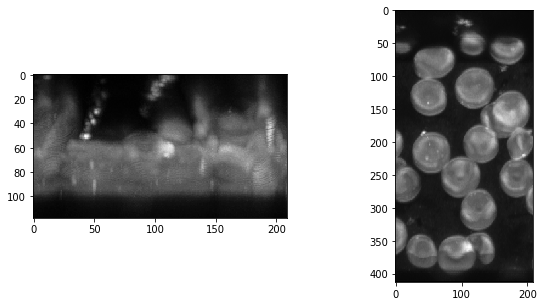

In [2]:
from skimage.io import imread,imsave
import pyclesperanto_prototype as cle
import matplotlib.pyplot as plt


img = imread("./RBC_lattice.tif")
voxel_size_x_in_microns = 0.145
voxel_size_y_in_microns = 0.145
voxel_size_z_in_microns = 0.3
deskewing_angle_in_degrees = 30
print(f"Raw Image shape {img.shape}")

deskewed_img = cle.deskew_y(input_image = img,
                            angle_in_degrees =deskewing_angle_in_degrees,
                            voxel_size_x=voxel_size_x_in_microns,
                            voxel_size_y= voxel_size_y_in_microns,
                            voxel_size_z=voxel_size_z_in_microns,
                            linear_interpolation=True)

print(f"Deskewed image shape {deskewed_img.shape}")

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

cle.imshow(img, plot=axs[0])
cle.imshow(deskewed_img, plot=axs[1])

Define code for segmentation based on [Interactive Workflows](https://github.com/BioimageAnalysisCoreWEHI/napari_lattice/wiki/5.-Workflows-(Interactive:-no-coding)#interactive)

* Gaussian blur
* Voronoi-Otsu labelling

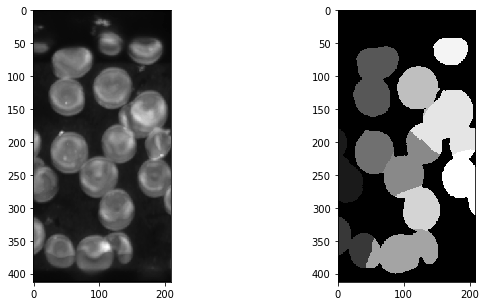

In [3]:
#Gaussian Blur
gaussian_img = cle.gaussian_blur(source = deskewed_img,
                             sigma_x = 1, 
                             sigma_y= 1,
                             sigma_z= 0)

#Voronoi_Otsu labelling
label_img = cle.voronoi_otsu_labeling(source = gaussian_img,
                                      spot_sigma = 14,
                                      outline_sigma=0)

fig1, axs1 = plt.subplots(1, 2, figsize=(10, 5))
cle.imshow(gaussian_img, plot=axs1[0],title="Gaussian")
cle.imshow(label_img, plot=axs1[1],title="Label")

Now, lets design a workflow using [napari-workflows](https://github.com/haesleinhuepf/napari-workflows)

In [4]:
#import workflow
from napari_workflows import Workflow

#We initialise a workflow
segmentation_workflow = Workflow()

#For each workflow , we need to define the name of the task, the function name and the function parameters
#For the input image, we only need to pass a variable or we pass the name of the previous workflow task_name


#Set task for gaussian blur first 
input_image = "input_img"

#To set a task, we use the set method
segmentation_workflow.set("gaussian",
                          cle.gaussian_blur,
                          source = input_image,
                          sigma_x = 1, 
                          sigma_y= 1,
                          sigma_z= 0)

#The second task will use input from above. so set the task name 'gaussian' as input 
segmentation_workflow.set("voronoi-otsu",
                          cle.voronoi_otsu_labeling,
                          source = "gaussian",
                          spot_sigma = 14,
                          outline_sigma=0)


#Printing a workflow will show you the arguments
print(segmentation_workflow)


Workflow:
gaussian <- (<function gaussian_blur at 0x0000021EEAA22E50>, 'input_img', None, 1, 1, 0)
voronoi-otsu <- (<function voronoi_otsu_labeling at 0x0000021EEAB34670>, 'gaussian', None, 14, 0)



So, now we have our segmentation workflow, lets test it 

In [ ]:
#We need to define the input image. For that, we use the set method, but we set the input_image variable to the actual image

segmentation_workflow.set(input_image,deskewed_img)

#You can see the image is the actual input
print(segmentation_workflow)


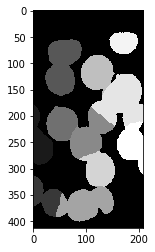

In [6]:
#To execute the workflow, we use the get method on the task of interest,
#Here, we want to get the output of voronoi-otsu labelling

label_img = segmentation_workflow.get("voronoi-otsu")

cle.imshow(label_img)

In [7]:
# To get region properties, we use the regionprops function from scikit-image
#regionprops_table will give a table for the properties

from skimage.measure import regionprops_table,marching_cubes,mesh_surface_area
import numpy as np

#convert cle array to numpy 
label_np = np.array(label_img)

measurements = regionprops_table(label_np, properties=( 'area',
                                                 'centroid',
                                                 'axis_major_length',
                                                 'axis_minor_length'))

measurements




{'area': array([ 54381,  35210,  80291,  54463,  72677,  62287,  59136,  52134,
        167322,  18443,  57644]),
 'centroid-0': array([28.9146393 , 18.51263845, 20.18619771, 18.76617153, 18.78756691,
        19.1934272 , 19.86781318, 20.6437066 , 26.11476674, 28.98481809,
        19.61512039]),
 'centroid-1': array([250.1634946 , 351.01403011, 110.58243141, 214.64105907,
        236.20870427, 361.25523785, 118.84669237, 300.73554686,
        171.84801759,  64.03871388, 253.02881479]),
 'centroid-2': array([ 12.34815469,  22.44072707,  54.65103187,  53.85557167,
        106.75455784, 101.5702474 , 120.70897592, 124.66588023,
        167.34990617, 171.27256954, 186.97557421]),
 'axis_major_length': array([116.01168133,  83.69194035, 123.00735317,  71.99602746,
        114.14616277, 124.90770932,  72.87620775,  73.09761053,
        103.77924888,  55.98654516,  99.06994141]),
 'axis_minor_length': array([36.32099211, 25.14695845, 27.26836547, 28.71541641, 26.07378731,
        22.44325742,

In most cases, we'd like to get images and tables as the output. There are a number of different ways we can do this. Lets generate a custom that takes a label image and returns a table as the output. We'll then use it to define a workflow.

In [ ]:
from skimage.measure import regionprops_table
import numpy as np

def measure_region_properties(label_img):
    label_np = np.array(label_img)
    measurements = regionprops_table(label_np, properties=( 'area',
                                                 'centroid',
                                                 'axis_major_length',
                                                 'axis_minor_length'))
    return measurements,label_img

measure_region_properties(label_img)

We can save the above function as a separate `.py` file. We can now access this as a python module using import statements. 
Within the same folder as this notebook, you'll find a file called `measure_regionprops.py` with the above `regionprops` function.  As long as the `py` file is in the same folder as the workflow, we can access it by using `import measure_regionprops`. You can give it any name you want, as long as you use the same name within the workflow file. 

PS: To create a `.py` file, you open a text editor, paste the code and then rename the `.txt` file with `.py`.

In [9]:
#Lets create a workflow with our custom function
#import workflow
from napari_workflows import Workflow
#importing our custom module
import measure_regionprops

#We initialise a workflow
segmentation_workflow = Workflow()

#For each workflow , we need to define the name of the task, the function name and the function parameters
#For the input image, we only need to pass a variable or we pass the name of the previous workflow task_name


#Set task for gaussian blur first 
input_image = "input_img"

#To set a task, we use the set method
segmentation_workflow.set("gaussian",
                          cle.gaussian_blur,
                          source = input_image,
                          sigma_x = 1, 
                          sigma_y= 1,
                          sigma_z= 0)

#The second task will use input from above. so set the task name 'gaussian' as input 
segmentation_workflow.set("voronoi-otsu",
                          cle.voronoi_otsu_labeling,
                          source = "gaussian",
                          spot_sigma = 14,
                          outline_sigma=0)


#Call the custom function and assign the previous step as the input image
segmentation_workflow.set("region_props",
                          measure_regionprops.measure_region_properties,
                          "voronoi-otsu"
                          )

print(segmentation_workflow)

Workflow:
gaussian <- (<function gaussian_blur at 0x0000021EEAA22E50>, 'input_img', None, 1, 1, 0)
voronoi-otsu <- (<function voronoi_otsu_labeling at 0x0000021EEAB34670>, 'gaussian', None, 14, 0)
region_props <- (<function measure_region_properties at 0x0000021E80C2B430>, 'voronoi-otsu')



Lets test it to make sure it works

{'area': array([ 54381,  35210,  80291,  54463,  72677,  62287,  59136,  52134,
       167322,  18443,  57644]), 'centroid-0': array([28.9146393 , 18.51263845, 20.18619771, 18.76617153, 18.78756691,
       19.1934272 , 19.86781318, 20.6437066 , 26.11476674, 28.98481809,
       19.61512039]), 'centroid-1': array([250.1634946 , 351.01403011, 110.58243141, 214.64105907,
       236.20870427, 361.25523785, 118.84669237, 300.73554686,
       171.84801759,  64.03871388, 253.02881479]), 'centroid-2': array([ 12.34815469,  22.44072707,  54.65103187,  53.85557167,
       106.75455784, 101.5702474 , 120.70897592, 124.66588023,
       167.34990617, 171.27256954, 186.97557421]), 'axis_major_length': array([116.01168133,  83.69194035, 123.00735317,  71.99602746,
       114.14616277, 124.90770932,  72.87620775,  73.09761053,
       103.77924888,  55.98654516,  99.06994141]), 'axis_minor_length': array([36.32099211, 25.14695845, 27.26836547, 28.71541641, 26.07378731,
       22.44325742, 26.42723016, 2

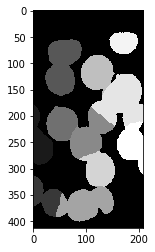

In [12]:
#To execute the workflow, we use the get method on the task of interest,
#Here, we get the output from regionprops, where we can get the measurement and the image

segmentation_workflow.set(input_image,deskewed_img)

measurements,label_img = segmentation_workflow.get("region_props")
print(measurements)
cle.imshow(label_img)

The segmentation workflow appears to be working. Now, we can save it to a yaml file.


In [14]:
from napari_workflows import _io_yaml_v1

_io_yaml_v1.save_workflow("regionprops_workflow.yml", segmentation_workflow)

To use this in `napari-lattice`, import it in under the `Workflow` tab.
You can try `Preview Workflow` to test it on a region or `Apply Workflow and Save` to apply it across a range of timepoints/channels.

Refer to the `napari-lattice Wiki` for more details